# Exploration

# Narrowing the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bisect

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
# Using 2016 data - stops and breakpoints

df_time_data = pd.read_csv("../Travel times 2016 of the VBZ in the target-performance comparison/fahrzeiten_soll_ist_20160103_20160109.csv")

# Bus stop
df_haltepunkt = pd.read_csv("../Travel times 2016 of the VBZ in the target-performance comparison/haltepunkt.csv")

# Bus Station
df_haltestelle = pd.read_csv("../Travel times 2016 of the VBZ in the target-performance comparison/haltestelle.csv")

####################
# Some useful atts #
####################

# Target attributes - from: in seconds
target_arrival_from = "soll_an_von"

# Actual attributes - from: in seconds
actual_arrival_from = "ist_an_von"

# nominal departure from in seconds
target_departure_from = "soll_ab_von"

# actual  departure from in seconds
actual_departure_from = "ist_ab_von"
#######################################

#######################################
# Target attributes - from: in seconds
target_arrival_to = "soll_an_nach"

# Actual attributes - from: in seconds
actual_arrival_to = "ist_an_nach1"

# nominal departure from in seconds
target_departure_to = "soll_ab_nach"

# actual  departure from in seconds
actual_departure_to = "ist_ab_nach"
#####################################

#####################################

# key to haltestelle from and to
halt_id_from = "halt_id_von"
halt_id_to = "halt_id_nach"

############################
# key to haltepunkt from and to
halt_punkt_id_from = "halt_punkt_id_von"
halt_punkt_id_to = "halt_punkt_id_nach"

###########################


# Narrow down to 1 day: 06.01.16 - DD.MM.YY
date_to_narrow = "06.01.16"
df_modified = df_time_data.loc[df_time_data['betriebsdatum'] == date_to_narrow]

# Narrow down to 1 vehicle: vehicle number
vehicle_number = 10087
df_modified = df_modified.loc[df_modified['fahrzeug'] == vehicle_number]

# Sorting by actual arrival time: to understand time structure
df_1 = df_modified.sort_values(by=[actual_arrival_from])
# Isolating the arrival and departure times
df_2 = df_1[[target_arrival_from, actual_arrival_from, target_departure_from, actual_departure_from,
             target_arrival_to, actual_arrival_to, target_departure_to, actual_departure_to, 'seq_von']]


# A glance at the dataset

In [2]:
df_time_data.head()

,linie,richtung,betriebsdatum,fahrzeug,kurs,seq_von,halt_diva_von,halt_punkt_diva_von,halt_kurz_von1,datum_von,soll_an_von,ist_an_von,soll_ab_von,ist_ab_von,seq_nach,halt_diva_nach,halt_punkt_diva_nach,halt_kurz_nach1,datum_nach,soll_an_nach,ist_an_nach1,soll_ab_nach,ist_ab_nach,fahrt_id,fahrweg_id,fw_no,fw_typ,fw_kurz,fw_lang,umlauf_von,halt_id_von,halt_id_nach,halt_punkt_id_von,halt_punkt_id_nach
0,918,1,06.01.16,11652,1,2,3744,50,ZENK,06.01.16,65880,65906,65898,65906,3,2043,50,RKIK,06.01.16,65988,65997,66000,65997,75165,5091,1,1,1,BKUE - GART,112395,2663,2796,6081,6661
1,2,2,06.01.16,3005,7,1,1357,3,KALK,07.01.16,2970,2986,2970,2986,2,6030,0,DEP4,07.01.16,3120,3316,3120,4539,44495,9829,20,3,20,KALK - DEP4 von FARB,114217,1906,2251,4284,5118
2,184,1,06.01.16,10266,2,4,6437,50,GRUT,06.01.16,51288,51335,51300,51344,5,2660,50,TIAK01,06.01.16,51360,51392,51372,51392,59724,9820,1,1,1,WOLL - BADL,114554,2160,2141,4954,4912
3,3,2,07.01.16,3024,2,19,2385,1,SIEM,07.01.16,58152,58149,58164,58166,20,840,1,FELL,07.01.16,58230,58226,58248,58248,44653,18094,2,1,2,KLUS - ALBR,113535,2640,2713,6026,6451
4,80,2,05.01.16,10421,12,7,2034,22,RAUT,06.01.16,3612,3601,3624,3601,8,1570,22,LIND,06.01.16,3702,3682,3714,3699,97583,12808,24,1,24,TRIE - BALT,113576,2543,2535,5899,5869


In [3]:
df_time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404616 entries, 0 to 1404615
Data columns (total 34 columns):
linie                   1404616 non-null int64
richtung                1404616 non-null int64
betriebsdatum           1404616 non-null object
fahrzeug                1404616 non-null int64
kurs                    1404616 non-null int64
seq_von                 1404616 non-null int64
halt_diva_von           1404616 non-null int64
halt_punkt_diva_von     1404616 non-null int64
halt_kurz_von1          1404616 non-null object
datum_von               1404616 non-null object
soll_an_von             1404616 non-null int64
ist_an_von              1404616 non-null int64
soll_ab_von             1404616 non-null int64
ist_ab_von              1404616 non-null int64
seq_nach                1404616 non-null int64
halt_diva_nach          1404616 non-null int64
halt_punkt_diva_nach    1404616 non-null int64
halt_kurz_nach1         1404616 non-null object
datum_nach              1404616 non-n

In [4]:
df_time_data.describe()

,linie,richtung,fahrzeug,kurs,seq_von,halt_diva_von,halt_punkt_diva_von,soll_an_von,ist_an_von,soll_ab_von,ist_ab_von,seq_nach,halt_diva_nach,halt_punkt_diva_nach,soll_an_nach,ist_an_nach1,soll_ab_nach,ist_ab_nach,fahrt_id,fahrweg_id,fw_no,fw_typ,fw_kurz,umlauf_von,halt_id_von,halt_id_nach,halt_punkt_id_von,halt_punkt_id_nach
count,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06,1.404616e+06
mean,9.925401e+01,1.500278e+00,6.932725e+03,5.610784e+00,1.141087e+01,1.982938e+03,1.347268e+01,5.051860e+04,5.054926e+04,5.053395e+04,5.056435e+04,1.241087e+01,1.982607e+03,1.347393e+01,5.054236e+04,5.057525e+04,5.055772e+04,5.060487e+04,6.418944e+04,1.885930e+04,3.121765e+00,1.005046e+00,3.121765e+00,1.124278e+05,2.258200e+03,2.258239e+03,5.541766e+03,5.540933e+03
std,1.922875e+02,5.000001e-01,3.996496e+03,3.987944e+00,7.748179e+00,1.392613e+03,1.710389e+01,1.976745e+04,1.977386e+04,1.976751e+04,1.977077e+04,7.748179e+00,1.392030e+03,1.710448e+01,1.978787e+04,1.979132e+04,1.978792e+04,1.979193e+04,2.897174e+04,5.301271e+03,9.881403e+00,9.023247e-02,9.881403e+00,3.739283e+03,4.898746e+02,4.899610e+02,1.488679e+03,1.488191e+03
min,2.000000e+00,1.000000e+00,2.001000e+03,1.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,-2.214300e+05,0.000000e+00,-7.000000e+01,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+02,0.000000e+00,-3.000000e+02,1.840800e+04,1.719000e+03,1.000000e+00,1.000000e+00,1.000000e+00,9.029300e+04,3.730000e+02,3.730000e+02,8.260000e+02,8.260000e+02
25%,1.000000e+01,1.000000e+00,3.011000e+03,2.000000e+00,5.000000e+00,1.012000e+03,1.000000e+00,3.456600e+04,3.459200e+04,3.458400e+04,3.460800e+04,6.000000e+00,1.012000e+03,1.000000e+00,3.460200e+04,3.462600e+04,3.462000e+04,3.465700e+04,4.711500e+04,1.823500e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.121230e+05,1.934000e+03,1.934000e+03,4.675000e+03,4.675000e+03
50%,3.200000e+01,2.000000e+00,1.008100e+04,5.000000e+00,1.000000e+01,1.643000e+03,1.000000e+01,5.118000e+04,5.121200e+04,5.119800e+04,5.122800e+04,1.100000e+01,1.643000e+03,1.000000e+01,5.121000e+04,5.125000e+04,5.122800e+04,5.127900e+04,5.189450e+04,2.061200e+04,2.000000e+00,1.000000e+00,2.000000e+00,1.130190e+05,2.414000e+03,2.414000e+03,5.668000e+03,5.668000e+03
75%,7.500000e+01,2.000000e+00,1.042000e+04,8.000000e+00,1.700000e+01,2.638000e+03,2.000000e+01,6.655200e+04,6.658800e+04,6.657000e+04,6.660400e+04,1.800000e+01,2.638000e+03,2.000000e+01,6.660000e+04,6.663700e+04,6.661800e+04,6.666800e+04,7.922000e+04,2.229900e+04,2.000000e+00,1.000000e+00,2.000000e+00,1.139930e+05,2.637000e+03,2.637000e+03,6.363000e+03,6.363000e+03
max,9.190000e+02,2.000000e+00,1.166400e+04,6.600000e+01,3.400000e+01,6.961000e+03,6.100000e+01,8.639400e+04,8.901700e+04,8.646000e+04,8.904200e+04,3.500000e+01,6.961000e+03,6.100000e+01,8.639400e+04,8.901700e+04,8.646000e+04,9.044700e+04,1.418950e+05,2.479500e+04,1.080000e+02,3.000000e+00,1.080000e+02,1.149400e+05,3.135000e+03,3.135000e+03,1.033300e+04,1.033300e+04


# Questions: 

What do these attributes mean? and how are the values distributed? The answer to this question can be found in the Dataset overview file, with details about what each attribute represent. But, here are some important ones.

    seq_von - sequence of stops in a given route - from
    
    seq_nach - sequence of stops in a given route - to
    
    betriebsdatum - date of data recording
    
    target_arrival_from = "soll_an_von"

    actual_arrival_from = "ist_an_von"

    target_departure_from = "soll_ab_von"

    actual_departure_from = "ist_ab_von"
    
    fahrt_id - unique ride id
    
    fahrweg_id - unique route id - useful for keeping track of a stop sequence
    
    fw_typ - type of transportation
    
    halt_id_von and nach, halt_punkt_id_von and nach - keys to Haltestelle and Haltepunkt

In [5]:
# The datapoints distribution of target departures
%matplotlib
df_time_data.soll_ab_von.hist()
plt.xlabel('time of the day')
plt.ylabel('nunber of datapoints')

Using matplotlib backend: Qt5Agg


Text(0, 0.5, 'nunber of datapoints')

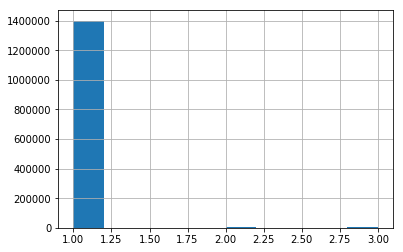

In [6]:
df_time_data.fw_typ.hist()

Validation - Confirm redundancy of some data points
    Makinig sure that the datapoints, from and to, are repeated correctly at each time step
    by moving the dataset by 1 value for each row, and comparing.

In [7]:
# Confirming that at each time step, the to is redundant:
df_2[target_arrival_from] = df_2[target_arrival_from].shift(-1)
df_2[actual_arrival_from] = df_2[actual_arrival_from].shift(-1)
df_2[target_departure_from] = df_2[target_departure_from].shift(-1)
df_2[actual_departure_from] = df_2[actual_departure_from].shift(-1)

df_2['res1'] = df_2[target_arrival_from] - df_2[target_arrival_to]
df_2['res2'] = df_2[actual_arrival_from] - df_2[actual_arrival_to]
df_2['res3'] = df_2[target_departure_from] - df_2[target_departure_from]
df_2['res4'] = df_2[actual_departure_from] - df_2[actual_departure_to]

# Every time the seq_von, which is the sequence of rides, changes from (cycle is over, and repeats), there seems to be
# a gap in the data

In [8]:
df_2.head()

,soll_an_von,ist_an_von,soll_ab_von,ist_ab_von,soll_an_nach,ist_an_nach1,soll_ab_nach,ist_ab_nach,seq_von,res1,res2,res3,res4
429956,23238.0,23273.0,23238.0,23273.0,23220,23273,23220,23273,1,18.0,0.0,0.0,0.0
1067239,23286.0,23318.0,23304.0,23347.0,23286,23318,23304,23347,1,0.0,0.0,0.0,0.0
1282913,23346.0,23394.0,23358.0,23398.0,23346,23394,23358,23398,2,0.0,0.0,0.0,0.0
822526,23400.0,23443.0,23418.0,23466.0,23400,23443,23418,23466,3,0.0,0.0,0.0,0.0
52950,23472.0,23526.0,23484.0,23539.0,23472,23526,23484,23539,4,0.0,0.0,0.0,0.0


In [9]:
# datapoints that are non equal
len(df_2[df_2.res1 != 0])

23

In [10]:
# number of each trip - unique
len(set(df_1.fahrt_id))

23

The results above match, meaning that there are no anamolies in redundancy

In [11]:
# To see how many unique punkt ids we have
len(set(df_1['halt_punkt_id_nach']))

60

How are the delays - meaning the difference between the actual and arrival times - distributed for a give day, and a given bus number?

In [6]:
%matplotlib
df_2['delay'] = df_2[actual_arrival_from] - df_2[target_arrival_from]
df_1['delay'] = df_1[actual_arrival_from] - df_1[target_arrival_from]
# Finding the delay
df_2[target_departure_from] = df_2[target_departure_from].shift(-1)

df_2['res3'] = df_2[target_departure_from] - df_2[target_departure_to]

df_2['course_change'] = df_2['res3'] > 0

colors = []

for i in df_2['course_change']:
    colors.append('b' if i is True else 'k')

# Coloring the mentioned points differently

# Plotting code
# - blue points indicate course direction change
plt.scatter(np.array([i for i in range(len(df_2))]), df_2['delay'].tolist(), c=colors)
plt.title("Delay of bus number " + str(vehicle_number) + " in seconds - (actual - target) on day " + date_to_narrow)
plt.xlabel("data point number (instance) in order")
plt.ylabel("delay on seconds")
plt.show()

Using matplotlib backend: Qt5Agg


How are delays distibuted by the time intervals of the day? - plotting each time intervals (set to 30 mins each)

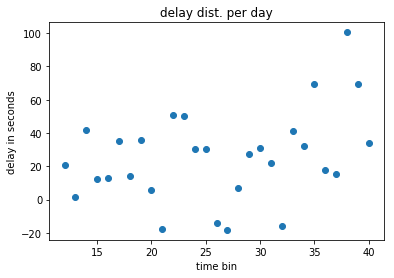

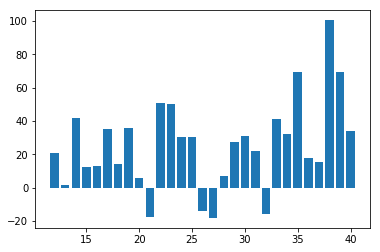

In [13]:
time_period = 1800
starting_time = 0
# indicates 30 mins intervals
# Number of bins:
n_bins = int(np.floor((86400 - starting_time)/time_period))
labels = [i for i in range(n_bins - 1)]
# Finding the correct bins:
list_of_bins = [starting_time + time_period * i for i in range(n_bins)]
# intervals = pd.interval_range(start=21600, end=86400, periods=n_bins)
df_1['intervals'] = pd.cut(df_1[target_departure_from], bins=list_of_bins, retbins=False, labels=labels)
# plt.scatter(df_2['intervals'], df_2['delay'])
# plt.xlim(0, n_bins+2)
# plt.show()

df_1 = df_1.groupby(by='intervals', as_index=False).mean()

plt.title('delay dist. per day')
plt.xlabel('time bin')
plt.ylabel('delay in seconds')

plt.scatter(df_1.intervals.values, df_1.delay)
plt.show()

plt.bar(df_1.intervals.values, df_1.delay)
plt.show()



Are delays distributed differently by the day? - below, all of the fridays of the first quarter of 2016 is loaded for analysis.

In [14]:
list_of_dfs = []
for i in range(12):
    # df = pd.read_csv(str(i+1)+".csv")
    df = pd.read_csv(str(i + 1) + '-f' + ".csv")
    list_of_dfs.append(df)

final_df = pd.concat(list_of_dfs)
final_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [15]:
df_2 = final_df[[target_arrival_from, actual_arrival_from, target_departure_from, actual_departure_from,
             target_arrival_to, actual_arrival_to, target_departure_to, actual_departure_to, 'kurs']]

In [16]:
# Now, finding where the route is changing, i.e. the direction is changing or the sequence is resetting. These points
# seem to introduce a significant amount of delay, therefore going to remove these points, as it seems like the bus
# is waiting for a particular reason at the spot before changing its course

df_2['delay'] = df_2[actual_arrival_from] - df_2[target_arrival_from]
df_2[target_departure_from] = df_2[target_departure_from].shift(-1)

df_2['res3'] = df_2[target_departure_from] - df_2[target_departure_to]

df_2['course_change'] = df_2['res3'] > 0

df_2 = df_2[df_2['course_change'] == False]

df_2 = df_2[abs(df_2['delay']) < 3600]

In [17]:
%matplotlib
time_period = 1800
starting_time = 0
# indicates 30 mins intervals
# Number of bins:
n_bins = int(np.floor((86400 - starting_time)/time_period))
labels = [i for i in range(n_bins - 1)]
# Finding the correct bins:
list_of_bins = [starting_time + time_period * i for i in range(n_bins)]
df_2['intervals'] = pd.cut(df_2[target_arrival_from], bins=list_of_bins, retbins=False, labels=labels)


avgs_target = []
avgs_actual = []
# Averaging:
for i in labels:
    avgs_target.append(df_2[df_2['intervals'] == i].mean()[target_arrival_from])
    avgs_actual.append(df_2[df_2['intervals'] == i].mean()[actual_arrival_from])
for i in range(len(avgs_actual)):
    if np.isnan(avgs_actual[i]):
        avgs_actual[i] = 0

fig, ax = plt.subplots()

x = np.array(labels)
# plt.bar(left=x-1, width=1, height=avgs_target)
# plt.bar(left=x, width=1, height=avgs_actual)

p1 = ax.bar(x, avgs_target, 1, color='r')
p2 = ax.bar(x + 1, avgs_actual, 1,
            color='y')
ax.autoscale_view()
plt.xlabel('time intervals')
plt.ylabel('departure vs arrival')
plt.show()

Using matplotlib backend: Qt5Agg
